In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np 
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from scipy.stats import median_abs_deviation

https://www.google.com/imgres?imgurl=https%3A%2F%2Fcxl.com%2Fwp-content%2Fuploads%2F2017%2F01%2Fchart-1.png&tbnid=RClfEFYNWm0WWM&vet=12ahUKEwjsx9KiqtKDAxXwh_0HHQR0CPoQMygSegQIARB1..i&imgrefurl=https%3A%2F%2Fcxl.com%2Fblog%2Foutliers%2F&docid=EVGldozQCNsxLM&w=1662&h=722&q=outliers%20different%20distributions&client=safari&ved=2ahUKEwjsx9KiqtKDAxXwh_0HHQR0CPoQMygSegQIARB1

 source:
https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/outlier_detection_hampel_filter.ipynb


## define functions

In [2]:
def random_walk_with_outliers(origin, n_steps, perc_outliers=0.0, outlier_mult=10, seed=42):
    '''
    Function for generating a random time series based on random walk.
    It adds a specified percentage of outliers by multiplying the random walk step by a scalar.
    
    Parameters
    ------------
    origin : int
        The starting point of the series
    n_steps : int
        Lenght of the series
    perc_outliers : float
        Percentage of outliers to introduce to the series [0.0-1.0]
    outlier_mult : float
        Scalar by which to multiply the RW increment to create an outlier
    seed : int
        Random seed

    Returns
    -----------
    rw : np.ndarray
        The generated random walk series with outliers
    indices : np.ndarray
        The indices of the introduced outliers 
    '''
    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)
    
    #set seed for reproducibility
    np.random.seed(seed)
    
    # possible steps
    steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)
    
    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult
    
    return rw, indices

def concise(ax):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

## load and process data

In [4]:
start = '2023-01-10 00:00:00'
n_steps = 1000
rw39, outlier_ind39 = random_walk_with_outliers(origin=0,
                                            n_steps=n_steps,
                                            perc_outliers=0.0031,
                                            outlier_mult=50,
                                            seed=39)
date_range = pd.date_range(start, periods=n_steps, freq='1min')
df = pd.DataFrame({'date': date_range, 'signal': rw39}).set_index('date')
start = df.index[0]
end = df.index[-1]

In [5]:
rw40, outlier_ind40 = random_walk_with_outliers(origin=0,
                                            n_steps=n_steps,
                                            perc_outliers=0.0031,
                                            outlier_mult=50,
                                            seed=40)
df['signal40'] = rw40

df.loc['2023-01-10 04:40:00', 'signal40'] = 43.0

In [5]:
# rw41, outlier_ind41 = random_walk_with_outliers(origin=0,
#                                             n_steps=n_steps,
#                                             perc_outliers=0.0031,
#                                             outlier_mult=50,
#                                             seed=41)
# df['signal41'] = rw41

## stationary signal

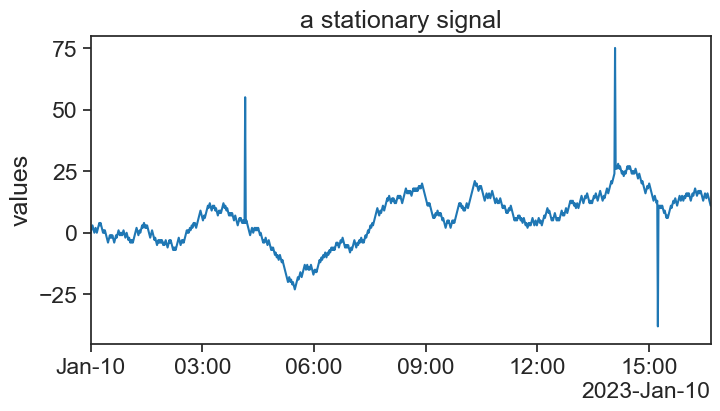

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
# plot signal
ax.plot(df['signal'], color="tab:blue")
# make graph look nice
ax.set(ylabel='values',
       xlim=[start,end],
       title="a stationary signal",
       ylim=[-45, 80])
concise(ax)
fig.savefig("signal_39_stationary.png", bbox_inches='tight')

## visual inspection

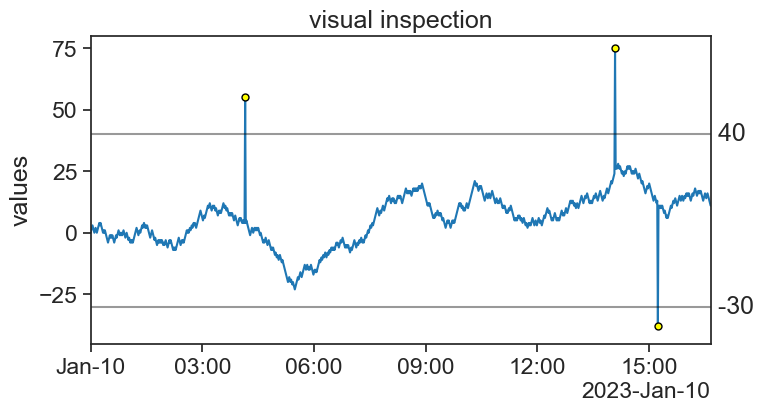

In [7]:
fig, ax = plt.subplots(figsize=(8,4))
# plot signal
ax.plot(df['signal'], color="tab:blue")
# plot horizontal lines
ax.plot([start, end], [40]*2, color="black", alpha=0.4)
ax.text(end, 40, " 40", va="center")
ax.plot([start, end], [-30]*2, color="black", alpha=0.4)
ax.text(end, -30, " -30", va="center")
# find and plot outliers
outliers_index = df.index[(df['signal'] > 40) | (df['signal'] < -30)]
ax.plot(df.loc[outliers_index, 'signal'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")
# make graph look nice
ax.set(ylabel='values',
       xlim=[start,end],
       title="visual inspection",
       ylim=[-45, 80])
concise(ax)
fig.savefig("outliers_visual_inspection.png", bbox_inches='tight')

## mean +- 3 std

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_73326/653833997.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


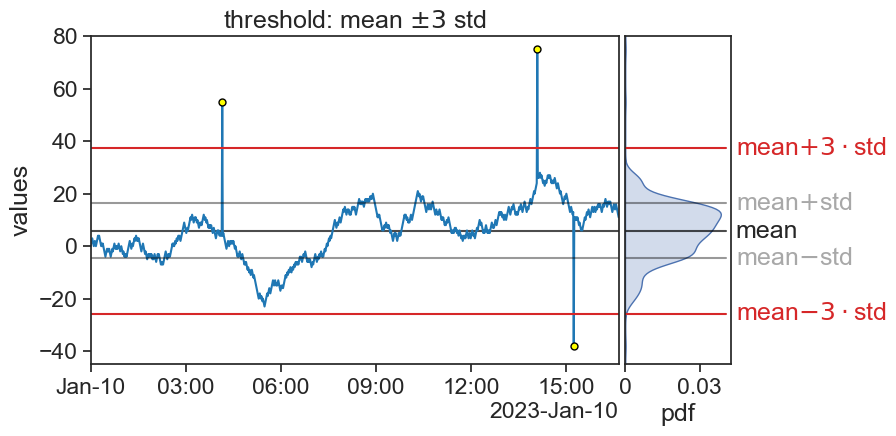

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.2], height_ratios=[1])
gs.update(left=0.10, right=0.90, top=0.95, bottom=0.13,
          hspace=0.02, wspace=0.02)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

avg = df['signal'].mean()
std = df['signal'].std()

# plot signal
ax0.plot(df['signal'], color="tab:blue")

sns.kdeplot(data=df, y='signal', shade=True, ax=ax1)

pdf_xlim = ax1.get_xlim()
# plot horizontal lines
# mean
ax0.plot([start, end], [avg]*2, color="black", zorder=-10, alpha=0.7)
ax1.plot(pdf_xlim, [avg]*2, color="black", alpha=0.7)
ax1.text(1.1*pdf_xlim[1], avg, "mean", va="center")
# mean + std
ax0.plot([start, end], [avg+std]*2, color="black", alpha=0.4)
ax1.plot(pdf_xlim, [avg+std]*2, color="black", alpha=0.4)
ax1.text(1.1*pdf_xlim[1], avg+std, r"mean$+$std", va="center", alpha=0.4)
# mean - std
ax0.plot([start, end], [avg-std]*2, color="black", alpha=0.4)
ax1.plot(pdf_xlim, [avg-std]*2, color="black", alpha=0.4)
ax1.text(1.1*pdf_xlim[1], avg-std, r"mean$-$std", va="center", alpha=0.4)

n_sigma = 3
# mean + 3std
ax0.plot([start, end], [avg+n_sigma*std]*2, color="tab:red")
ax1.plot(pdf_xlim, [avg+n_sigma*std]*2, color="tab:red")
ax1.text(1.1*pdf_xlim[1], avg+n_sigma*std, r"mean$+3\cdot$std", va="center", color="tab:red")
# mean - 3std
ax0.plot([start, end], [avg-n_sigma*std]*2, color="tab:red")
ax1.plot(pdf_xlim, [avg-n_sigma*std]*2, color="tab:red")
ax1.text(1.1*pdf_xlim[1], avg-n_sigma*std, r"mean$-3\cdot$std", va="center", color="tab:red")

# find and plot outliers
outliers_index = df.index[(df['signal'] > avg + n_sigma*std) | 
                          (df['signal'] < avg - n_sigma*std)
                         ]
ax0.plot(df.loc[outliers_index, 'signal'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")
# make graph look nice
ax0.set(ylabel='values',
       xlim=[start,end],
       ylim=[-45, 80],
       title=r"threshold: mean $\pm3$ std",
       )
concise(ax0)
ax1.set(xlabel='pdf',
        ylabel='',
        ylim=[-45, 80],
        yticks=[],
        xticks=[0, 0.03],
        xticklabels=['0', '0.03']
        )
fig.savefig("outliers_3sigma.png", bbox_inches='tight')

## IQR

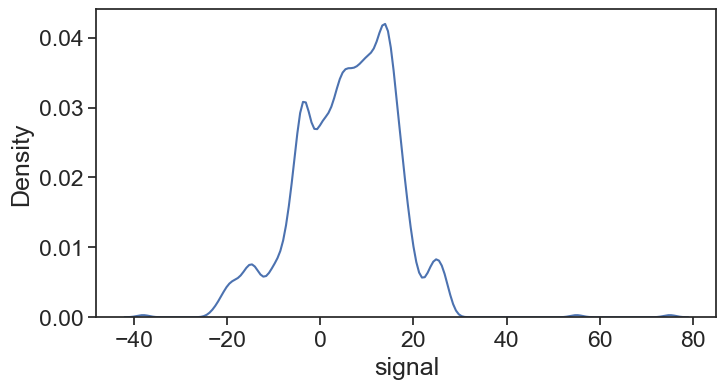

In [9]:
# get kdeplot data
fig, ax = plt.subplots(figsize=(8,4))
my_kde = sns.kdeplot(df['signal'], bw_adjust=0.5)
line = my_kde.lines[0]
kde_vals, kde_pdf = line.get_data()
kde_cdf = np.cumsum(kde_pdf) / np.sum(kde_pdf)

def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

# Find the boundaries where the KDE is 25% and 75% of the area
Q1_index = find_nearest(kde_cdf, 0.25)
Q1_boundary = kde_vals[Q1_index]
Q3_index = find_nearest(kde_cdf, 0.75)
Q3_boundary = kde_vals[Q3_index]
IQR = Q3_boundary - Q1_boundary

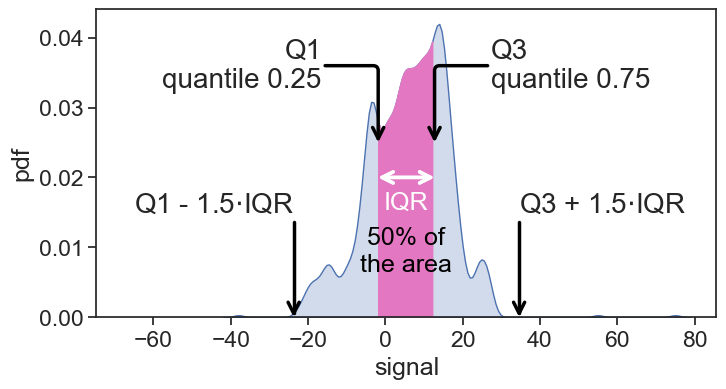

In [10]:
fig, ax = plt.subplots(figsize=(8,4))

sns.kdeplot(df['signal'], ax=ax, shade=True, bw_adjust=0.5)

ax.fill_between(x=kde_vals[Q1_index:Q3_index],
                y1=kde_pdf[Q1_index:Q3_index],
                color="tab:pink"
                )

h = 0.02
ax.annotate("",
            xy=(Q1_boundary, h), xycoords='data',
            xytext=(Q3_boundary, h), textcoords='data',
            size=20,
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3,rad=0.0",
                            shrinkA=0, shrinkB=0,
                            linewidth=2.5
                            ),
            )
ax.annotate("",
            xy=(Q1_boundary, h), xycoords='data',
            xytext=(Q3_boundary, h), textcoords='data',
            size=20,
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3,rad=0.0",
                            shrinkA=0, shrinkB=0,
                            linewidth=2.5
                            ),
            )

ax.annotate("Q1\nquantile 0.25",
            xy=(Q1_boundary, 0.025), xycoords='data',
            xytext=(Q1_boundary-IQR, 0.040), textcoords='data',
            size=20,
            ha="right",
            va="top",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=5",
                            shrinkA=0, shrinkB=0,
                            linewidth=2.5,
                            color="black"
                            ),
            )

ax.annotate("Q3\nquantile 0.75",
            xy=(Q3_boundary, 0.025), xycoords='data',
            xytext=(Q3_boundary+IQR, 0.040), textcoords='data',
            size=20,
            ha="left",
            va="top",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=5",
                            shrinkA=0, shrinkB=0,
                            linewidth=2.5,
                            color="black"
                            ),
            )

ax.annotate(r"Q3 + 1.5$\cdot$IQR",
            xy=(Q3_boundary+1.5*IQR, 0.00), xycoords='data',
            xytext=(Q3_boundary+1.5*IQR, 0.015), textcoords='data',
            size=20,
            ha="left",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=5",
                            shrinkA=0, shrinkB=0,
                            linewidth=2.5,
                            color="black"
                            ),
            )

ax.annotate(r"Q1 - 1.5$\cdot$IQR",
            xy=(Q1_boundary-1.5*IQR, 0.00), xycoords='data',
            xytext=(Q1_boundary-1.5*IQR, 0.015), textcoords='data',
            size=20,
            ha="right",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=5",
                            shrinkA=0, shrinkB=0,
                            linewidth=2.5,
                            color="black"
                            ),
            )

ax.text(Q1_boundary+IQR/2, 0.018, "IQR",
        ha="center", va="top", color="white")
ax.text(Q1_boundary+IQR/2, 0.013, r"50% of"+"\nthe area",
        ha="center", va="top", color="black")

ax.set(xlim=[Q1_boundary-5*IQR, Q3_boundary+5*IQR],
       ylabel="pdf",)
fig.savefig("IQR_pdf.png", bbox_inches='tight')

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_73326/3077230861.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


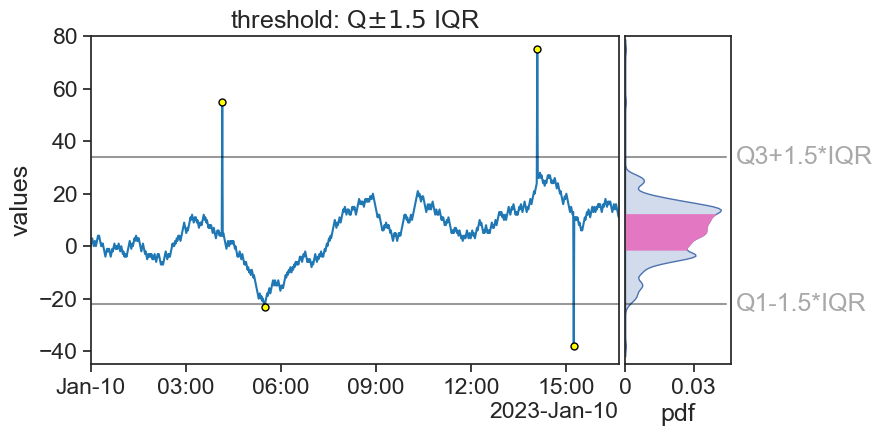

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.2], height_ratios=[1])
gs.update(left=0.10, right=0.90, top=0.95, bottom=0.13,
          hspace=0.02, wspace=0.02)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

median = df['signal'].quantile(0.50)
Q1 = df['signal'].quantile(0.25)
Q3 = df['signal'].quantile(0.75)
IQR = Q3 - Q1

# plot signal
ax0.plot(df['signal'], color="tab:blue")

my_kde = sns.kdeplot(data=df, y='signal', shade=True, ax=ax1, bw_adjust=0.5)
pdf_xlim =ax1.get_xlim()

kde_q1_idx = find_nearest(kde_vals, Q1)
kde_q3_idx = find_nearest(kde_vals, Q3)
ax1.fill_betweenx(y=kde_vals[kde_q1_idx:kde_q3_idx],
                  x1=kde_pdf[kde_q1_idx:kde_q3_idx],
                  color="tab:pink")
# plot horizontal lines
# Q3 + 1.5 IQR
ax0.plot([start, end], [Q3+1.5*IQR]*2, color="black", alpha=0.4)
ax1.plot(pdf_xlim, [Q3+1.5*IQR]*2, color="black", alpha=0.4)
ax1.text(1.1*pdf_xlim[1], Q3+1.5*IQR, "Q3+1.5*IQR", va="center", alpha=0.4)
# Q1 - 1.5 IQR
ax0.plot([start, end], [Q1-1.5*IQR]*2, color="black", alpha=0.4)
ax1.plot(pdf_xlim, [Q1-1.5*IQR]*2, color="black", alpha=0.4)
ax1.text(1.1*pdf_xlim[1], Q1-1.5*IQR, "Q1-1.5*IQR", va="center", alpha=0.4)

# find and plot outliers
outliers_index = df.index[(df['signal'] > Q3+1.5*IQR) | 
                          (df['signal'] < Q1-1.5*IQR)
                         ]
ax0.plot(df.loc[outliers_index, 'signal'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")
# make graph look nice
ax0.set(ylabel='values',
       xlim=[start,end],
       ylim=[-45, 80],
       title=r"threshold: Q$\pm1.5$ IQR",
       )
concise(ax0)
ax1.set(xlabel='pdf',
        ylabel='',
        ylim=[-45, 80],
        yticks=[],
        xticks=[0, 0.03],
        xticklabels=['0', '0.03']
        )
fig.savefig("outliers_1.5IQR.png", bbox_inches='tight')

## non stationary signal

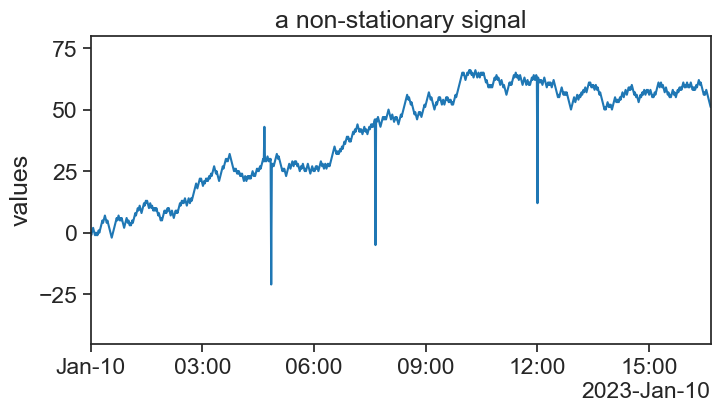

In [12]:
fig, ax = plt.subplots(figsize=(8,4))
# plot signal
ax.plot(df['signal40'], color="tab:blue")
# make graph look nice
ax.set(ylabel='values',
       xlim=[start,end],
       title="a non-stationary signal",
       ylim=[-45, 80])
concise(ax)
fig.savefig("signal_40_non_stationary.png", bbox_inches='tight')

## running +- 3 std

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_73326/372016966.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


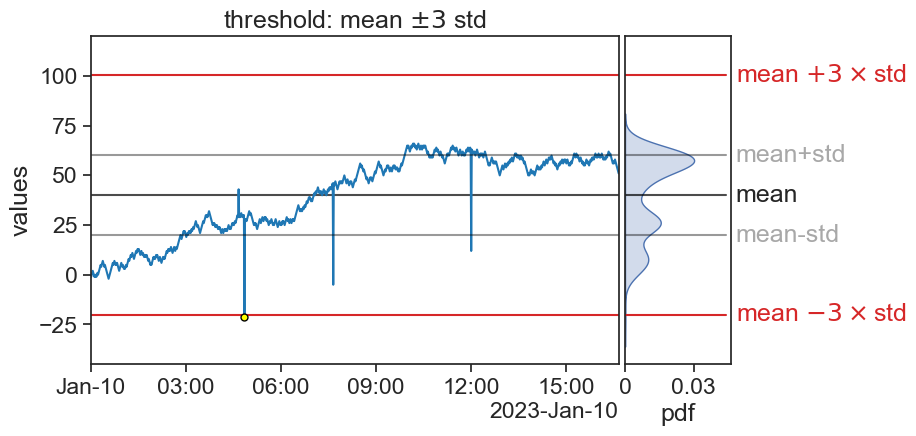

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.2], height_ratios=[1])
gs.update(left=0.10, right=0.90, top=0.95, bottom=0.13,
          hspace=0.02, wspace=0.02)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

avg = df['signal40'].mean()
std = df['signal40'].std()

# plot signal
ax0.plot(df['signal40'], color="tab:blue")

sns.kdeplot(data=df, y='signal40', shade=True, ax=ax1)


# plot horizontal lines
# mean
ax0.plot([start, end], [avg]*2, color="black", zorder=-10, alpha=0.7)
ax1.plot(pdf_xlim, [avg]*2, color="black", alpha=0.7)
ax1.text(1.1*pdf_xlim[1], avg, "mean", va="center")
# mean + std
ax0.plot([start, end], [avg+std]*2, color="black", alpha=0.4)
ax1.plot(pdf_xlim, [avg+std]*2, color="black", alpha=0.4)
ax1.text(1.1*pdf_xlim[1], avg+std, "mean+std", va="center", alpha=0.4)
# mean - std
ax0.plot([start, end], [avg-std]*2, color="black", alpha=0.4)
ax1.plot(pdf_xlim, [avg-std]*2, color="black", alpha=0.4)
ax1.text(1.1*pdf_xlim[1], avg-std, "mean-std", va="center", alpha=0.4)

n_sigma = 3
# mean + 3std
ax0.plot([start, end], [avg+n_sigma*std]*2, color="tab:red")
ax1.plot(pdf_xlim, [avg+n_sigma*std]*2, color="tab:red")
ax1.text(1.1*pdf_xlim[1], avg+n_sigma*std, r"mean $+3\times$std", va="center", color="tab:red")
# mean - 3std
ax0.plot([start, end], [avg-n_sigma*std]*2, color="tab:red")
ax1.plot(pdf_xlim, [avg-n_sigma*std]*2, color="tab:red")
ax1.text(1.1*pdf_xlim[1], avg-n_sigma*std, r"mean $-3\times$std", va="center", color="tab:red")

# find and plot outliers
outliers_index = df.index[(df['signal40'] > avg + n_sigma*std) | 
                          (df['signal40'] < avg - n_sigma*std)
                         ]
ax0.plot(df.loc[outliers_index, 'signal40'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")
# make graph look nice
ax0.set(ylabel='values',
       xlim=[start,end],
       ylim=[-45, 120],
       title=r"threshold: mean $\pm3$ std",
       )
concise(ax0)
ax1.set(xlabel='pdf',
        ylabel='',
        ylim=[-45, 120],
        yticks=[],
        xticks=[0, 0.03],
        xticklabels=['0', '0.03']
        )
fig.savefig("outliers_3sigma_seed40.png", bbox_inches='tight')

In [14]:
df['signal40_rol_mean'] = df['signal40'].rolling('60min', center=True).mean()
df['signal40_rol_std'] = df['signal40'].rolling('60min', center=True).std()

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_73326/142534422.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


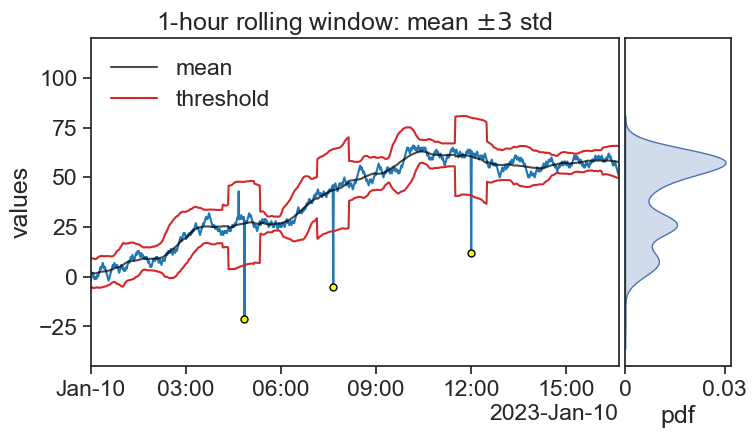

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.2], height_ratios=[1])
gs.update(left=0.10, right=0.90, top=0.95, bottom=0.13,
          hspace=0.02, wspace=0.02)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

avg = df['signal40'].mean()
std = df['signal40'].std()

# plot signal
ax0.plot(df['signal40'], color="tab:blue")

sns.kdeplot(data=df, y='signal40', shade=True, ax=ax1)

# mean
ax0.plot(df['signal40_rol_mean'], color="black", alpha=0.7, label="mean")
# mean +- 3 std
n_sigma = 3
ax0.plot(df['signal40_rol_mean']+ n_sigma*df['signal40_rol_std'], color="tab:red")
plot_threshold, = ax0.plot(df['signal40_rol_mean']- n_sigma*df['signal40_rol_std'],
                           color="tab:red", label="threshold")

# find and plot outliers
outliers_index = df.index[(df['signal40'] > df['signal40_rol_mean']+ n_sigma*df['signal40_rol_std']) | 
                          (df['signal40'] < df['signal40_rol_mean']- n_sigma*df['signal40_rol_std'])
                         ]
ax0.plot(df.loc[outliers_index, 'signal40'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")
# make graph look nice
ax0.set(ylabel='values',
       xlim=[start,end],
       ylim=[-45, 120],
       title=r"1-hour rolling window: mean $\pm3$ std",
       )
concise(ax0)
ax1.set(xlabel='pdf',
        ylabel='',
        ylim=[-45, 120],
        yticks=[],
        xticks=[0, 0.03],
        xticklabels=['0', '0.03']
        )
ax0.legend(frameon=False, loc="upper left")

fig.savefig("outliers_rolling_3std.png", bbox_inches='tight')

## running: Q +- IQR

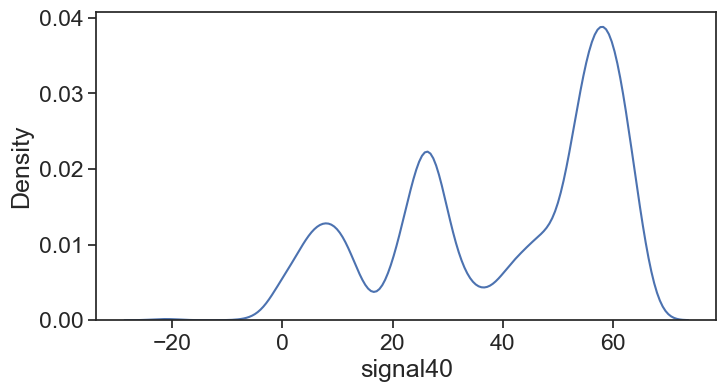

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

my_kde = sns.kdeplot(df['signal40'], bw_adjust=0.5)
line = my_kde.lines[0]
kde_vals, kde_pdf = line.get_data()
kde_cdf = np.cumsum(kde_pdf) / np.sum(kde_pdf)

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_73326/678430211.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


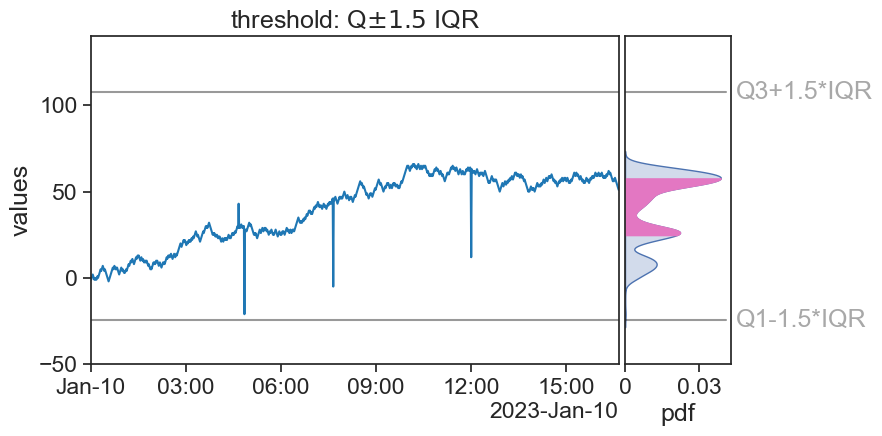

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.2], height_ratios=[1])
gs.update(left=0.10, right=0.90, top=0.95, bottom=0.13,
          hspace=0.02, wspace=0.02)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

median = df['signal40'].quantile(0.50)
Q1 = df['signal40'].quantile(0.25)
Q3 = df['signal40'].quantile(0.75)
IQR = Q3 - Q1

# plot signal
ax0.plot(df['signal40'], color="tab:blue")

my_kde = sns.kdeplot(data=df, y='signal40', shade=True, ax=ax1, bw_adjust=0.5)
pdf_xlim =ax1.get_xlim()

kde_q1_idx = find_nearest(kde_vals, Q1)
kde_q3_idx = find_nearest(kde_vals, Q3)
ax1.fill_betweenx(y=kde_vals[kde_q1_idx:kde_q3_idx],
                  x1=kde_pdf[kde_q1_idx:kde_q3_idx],
                  color="tab:pink")
# plot horizontal lines
# Q3 + 1.5 IQR
ax0.plot([start, end], [Q3+1.5*IQR]*2, color="black", alpha=0.4)
ax1.plot(pdf_xlim, [Q3+1.5*IQR]*2, color="black", alpha=0.4)
ax1.text(1.1*pdf_xlim[1], Q3+1.5*IQR, "Q3+1.5*IQR", va="center", alpha=0.4)
# Q1 - 1.5 IQR
ax0.plot([start, end], [Q1-1.5*IQR]*2, color="black", alpha=0.4)
ax1.plot(pdf_xlim, [Q1-1.5*IQR]*2, color="black", alpha=0.4)
ax1.text(1.1*pdf_xlim[1], Q1-1.5*IQR, "Q1-1.5*IQR", va="center", alpha=0.4)

# find and plot outliers
outliers_index = df.index[(df['signal40'] > Q3+1.5*IQR) | 
                          (df['signal40'] < Q1-1.5*IQR)
                         ]
ax0.plot(df.loc[outliers_index, 'signal40'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")
# make graph look nice
ax0.set(ylabel='values',
       xlim=[start,end],
       ylim=[-50, 140],
       title=r"threshold: Q$\pm1.5$ IQR",
       )
concise(ax0)
ax1.set(xlabel='pdf',
        ylabel='',
        ylim=[-50, 140],
        yticks=[],
        xticks=[0, 0.03],
        xticklabels=['0', '0.03']
        )
fig.savefig("outliers_1.5IQR_seed40.png", bbox_inches='tight')

In [18]:
def Q1(window):
    return window.quantile(0.25)
def Q3(window):
    return window.quantile(0.75)

In [19]:
df['signal40_rol_Q1'] = df['signal40'].rolling('60min', center=True).apply(Q1)
df['signal40_rol_Q3'] = df['signal40'].rolling('60min', center=True).apply(Q3)
df['signal40_rol_IQR'] = df['signal40_rol_Q3'] - df['signal40_rol_Q1']

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_73326/3108172465.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


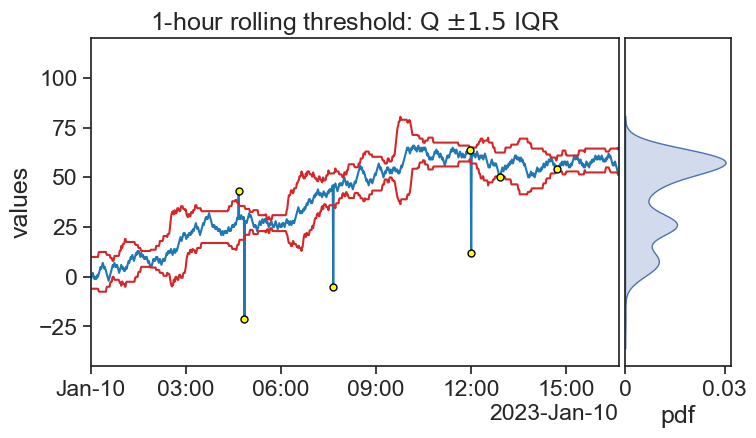

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.2], height_ratios=[1])
gs.update(left=0.10, right=0.90, top=0.95, bottom=0.13,
          hspace=0.02, wspace=0.02)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

avg = df['signal40'].mean()
std = df['signal40'].std()

# plot signal
ax0.plot(df['signal40'], color="tab:blue")

sns.kdeplot(data=df, y='signal40', shade=True, ax=ax1)

# median
# ax0.plot(df['signal40_rol_median'], color="black", alpha=0.7, label="median")
# Q1 - 1.5 IQR
threshold_bottom = df['signal40_rol_Q1'] - 1.5*df['signal40_rol_IQR']
ax0.plot(threshold_bottom, color="tab:red")
# Q3 + 1.5 IQR
threshold_top = df['signal40_rol_Q3'] + 1.5*df['signal40_rol_IQR']
ax0.plot(threshold_top, color="tab:red")

# find and plot outliers
outliers_index = df.index[(df['signal40'] > threshold_top) | 
                          (df['signal40'] < threshold_bottom)
                         ]
ax0.plot(df.loc[outliers_index, 'signal40'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")
# make graph look nice
ax0.set(ylabel='values',
       xlim=[start,end],
       ylim=[-45, 120],
       title=r"1-hour rolling threshold: Q $\pm1.5$ IQR",
       )
concise(ax0)
ax1.set(xlabel='pdf',
        ylabel='',
        ylim=[-45, 120],
        yticks=[],
        xticks=[0, 0.03],
        xticklabels=['0', '0.03']
        )

ax0.legend(frameon=False, loc="upper left")


fig.savefig("outliers_rolling_IQR.png", bbox_inches='tight')

## Hampel, running MAD

In [21]:
# def MAD(window):
#     return np.median(                                # 3. compute median
#                      np.abs(                         # 2. take absolute values
#                          window - np.median(window)  # 1. calculate residuals
#                          )
#                     )

k = 1.4826 # scale factor for Gaussian distribution
def MAD(window):
    return (window - np.median(window)).abs().median()


In [22]:
df['signal40_rol_mad'] = k * df['signal40'].rolling('60min', center=True).apply(MAD)
df['signal40_rol_median'] = df['signal40'].rolling('60min', center=True).median()

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_73326/3446982039.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


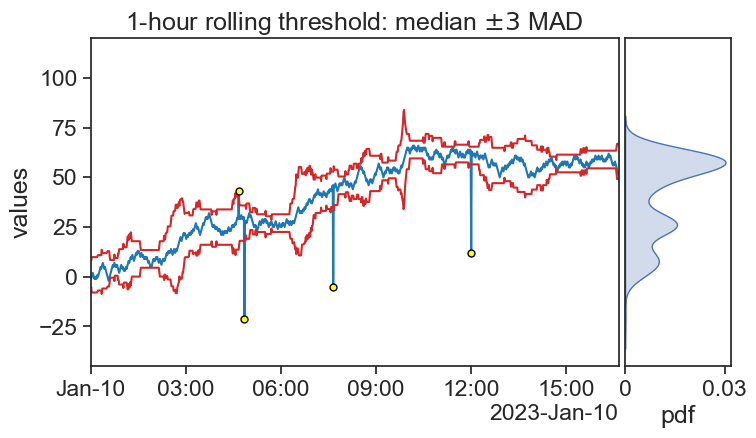

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.2], height_ratios=[1])
gs.update(left=0.10, right=0.90, top=0.95, bottom=0.13,
          hspace=0.02, wspace=0.02)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

# plot signal
ax0.plot(df['signal40'], color="tab:blue")

sns.kdeplot(data=df, y='signal40', shade=True, ax=ax1)

# median
# ax0.plot(df['signal40_rol_median'], color="black", alpha=0.7, label="median")
# Q1 - 1.5 IQR
threshold_bottom = df['signal40_rol_median'] - 3 * df['signal40_rol_mad']
ax0.plot(threshold_bottom, color="tab:red")
# Q3 + 1.5 IQR
threshold_top = df['signal40_rol_median'] + 3 * df['signal40_rol_mad']
ax0.plot(threshold_top, color="tab:red")

# find and plot outliers
outliers_index = df.index[(df['signal40'] > threshold_top) | 
                          (df['signal40'] < threshold_bottom)
                         ]
ax0.plot(df.loc[outliers_index, 'signal40'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")
# make graph look nice
ax0.set(ylabel='values',
       xlim=[start,end],
       ylim=[-45, 120],
       title=r"1-hour rolling threshold: median $\pm3$ MAD",
       )
concise(ax0)
ax1.set(xlabel='pdf',
        ylabel='',
        ylim=[-45, 120],
        yticks=[],
        xticks=[0, 0.03],
        xticklabels=['0', '0.03']
        )

ax0.legend(frameon=False, loc="upper left")


fig.savefig("outliers_rolling_MAD.png", bbox_inches='tight')

## stationary MAD

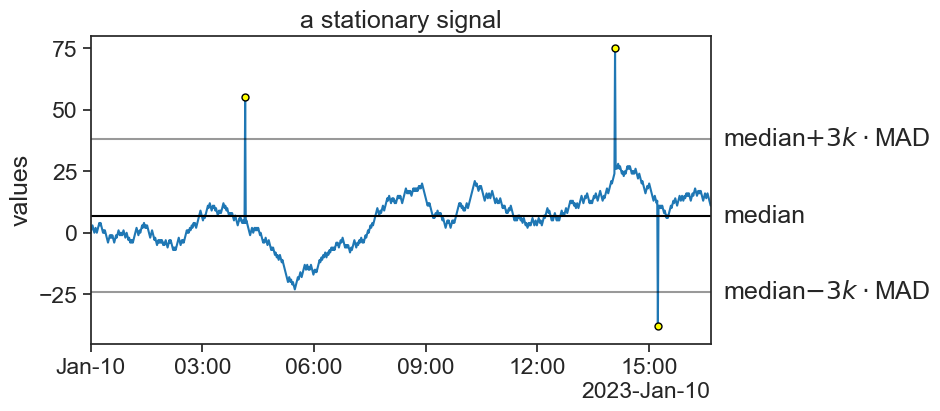

In [35]:
fig, ax = plt.subplots(figsize=(8,4))
# plot signal
ax.plot(df['signal'], color="tab:blue")

k = 1.4826 # scale factor for Gaussian distribution
mad = median_abs_deviation(df['signal'])
median = df['signal'].median()

xlim = ax.get_xlim()

# median +- 3*k*mad
ax.plot([start, end], [median]*2, color="black")
# ax.text(1.1, median, "median", va="center", transform=ax.transAxes,)

threshold_top = median+3*k*mad
threshold_bottom = median-3*k*mad

ax.plot([start, end], [threshold_bottom]*2, color="black", alpha=0.4)
ax.plot([start, end], [threshold_top]*2, color="black", alpha=0.4)

ax.annotate("median", xy=(1.02, median), xycoords=('axes fraction', 'data'),
            va='center')
ax.annotate(r"median$+3k\cdot$MAD", xy=(1.02, threshold_top), xycoords=('axes fraction', 'data'),
            va='center')
ax.annotate(r"median$-3k\cdot$MAD", xy=(1.02, threshold_bottom), xycoords=('axes fraction', 'data'),
            va='center')

# find and plot outliers
outliers_index = df.index[(df['signal'] > threshold_top) | 
                          (df['signal'] < threshold_bottom)
                         ]
ax.plot(df.loc[outliers_index, 'signal'], ls='None',
        marker='o', markerfacecolor='yellow', markersize=5,
        markeredgecolor="black")

# make graph look nice
ax.set(ylabel='values',
       xlim=[start,end],
       title="a stationary signal",
       ylim=[-45, 80])
concise(ax)
fig.savefig("outliers_MAD_stationary.png", bbox_inches='tight')

In [32]:
outliers_index

DatetimeIndex(['2023-01-10 04:09:00', '2023-01-10 14:05:00',
               '2023-01-10 15:14:00'],
              dtype='datetime64[ns]', name='date', freq=None)

## save data as csv for later usage

In [15]:
start = '2023-01-01 00:00:00'
end = '2023-12-31 23:55:00'
# date_range = pd.date_range(start, end, freq='5min')
date_range = pd.date_range(start, end, freq='1D')
n_steps = len(date_range)
rw39, outlier_ind39 = random_walk_with_outliers(origin=0,
                                            n_steps=n_steps,
                                            perc_outliers=0.0031,
                                            outlier_mult=50,
                                            seed=39)
# date_range = pd.date_range(start, periods=n_steps, freq='1min')
df = pd.DataFrame({'date': date_range, 'A': rw39}).set_index('date')

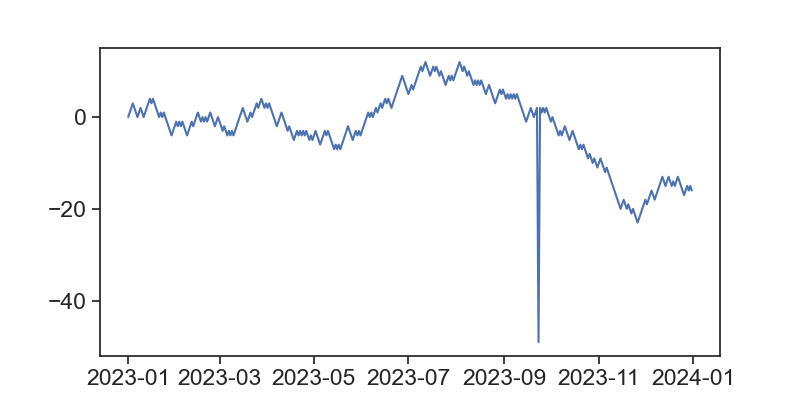

In [16]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df['A'])

In [21]:
df.loc['2023-03-02':'2023-03-10', 'A'] = -20.0

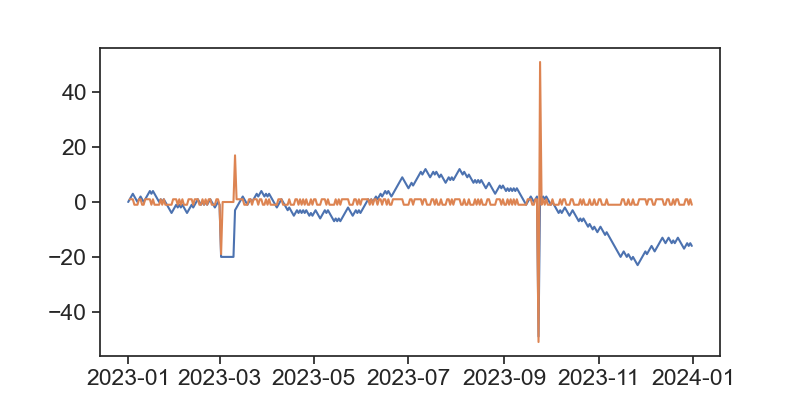

In [22]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,4))
df['Adiff'] = df['A'].diff()
ax.plot(df['A'])
ax.plot(df['Adiff'])

In [33]:
(df.loc['2023-03-03':'2023-03-06', 'Adiff'] == np.zeros(4)).all()

True

In [29]:
df.loc['2023-03-03':'2023-03-06', 'Adiff']

date
2023-03-03    0.0
2023-03-04    0.0
2023-03-05    0.0
2023-03-06    0.0
Name: Adiff, dtype: float64

In [28]:
np.zeros(4)

array([0., 0., 0., 0.])

In [34]:
n_consecutive = 2

def n_zeros(series, N):
    """
    True if all series equals np.zeros(N)
    False otherwise
    """
    return (series == np.zeros(N)).all()

In [55]:
df['mask1'] = df['Adiff'].rolling(n_consecutive).apply(n_zeros, args=(n_consecutive,))
df['mask'] = 0.0
for i in range(len(df)):
    if df['mask1'][i] == 1.0:
        df['mask'][i-n_consecutive:i+1] = 1.0

/var/folders/kv/9cqw3y_s6c75xmgqm9n0t5d40000gn/T/ipykernel_6180/2921310703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mask'][i-n_consecutive:i+1] = 1.0


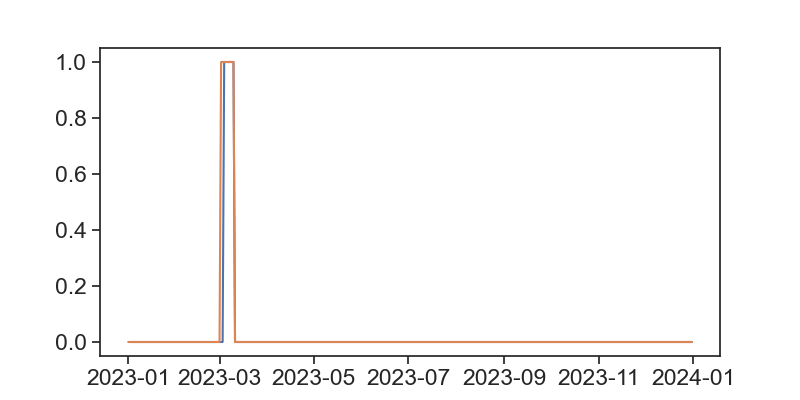

In [56]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df['mask1'])
ax.plot(df['mask'])

In [60]:
df['mask'] = 0.0
for j in range(len(df)-n_consecutive):
    if (df['Adiff'][j:j+n_consecutive] == np.zeros(n_consecutive)).all():
        df['mask'][j:j+n_consecutive] = 1.0

/var/folders/kv/9cqw3y_s6c75xmgqm9n0t5d40000gn/T/ipykernel_6180/2364603426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mask'][j:j+n_consecutive] = 1.0


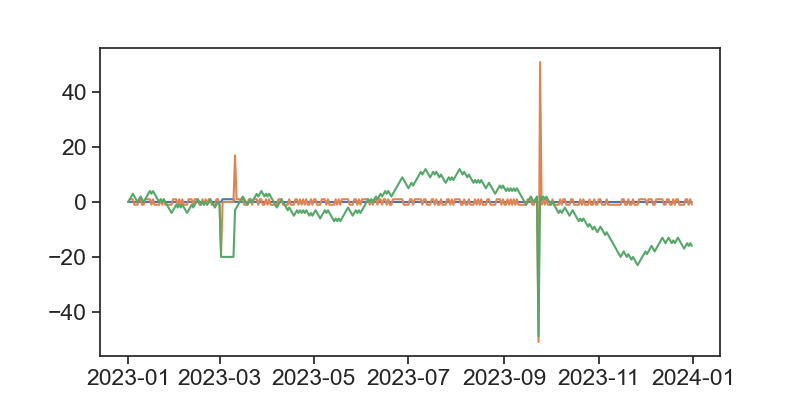

In [64]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(df['mask1'])
ax.plot(df['mask'])
ax.plot(df['Adiff'])
ax.plot(df['A'])

## generate datasets

In [3]:
def random_walk_with_outliers2(origin, steps_dist, outlier_dist, n_steps, perc_outliers=0.0, outlier_mult=10, seed=42):
    '''
    Function for generating a random time series based on random walk.
    It adds a specified percentage of outliers by multiplying the random walk step by a scalar.
    
    Parameters
    ------------
    origin : int
        The starting point of the series
    steps_dist : list of int or float
        step distribution
    outlier_dist : list of int or float
        outlier distribution
    n_steps : int
        Lenght of the series
    perc_outliers : float
        Percentage of outliers to introduce to the series [0.0-1.0]
    outlier_mult : float
        Scalar by which to multiply the RW increment to create an outlier
    seed : int
        Random seed

    Returns
    -----------
    rw : np.ndarray
        The generated random walk series with outliers
    indices : np.ndarray
        The indices of the introduced outliers 
    '''
    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)
    
    #set seed for reproducibility
    np.random.seed(seed)
    
    # possible steps
    # steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps_dist, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)
    
    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    outlier_jumps = np.random.choice(a=outlier_dist, size=n_outliers)
    # rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult
    rw[indices] = rw[indices] + outlier_jumps
    
    return rw, indices

In [66]:
rw39test, _ = random_walk_with_outliers2(origin=0,
                                       steps_dist=np.random.normal(size=1000),
                                       outlier_dist=10*np.random.normal(loc=5.0, size=100),
                                       n_steps=n_steps,
                                       perc_outliers=0.0002,
                                       outlier_mult=50,
                                       seed=206)

In [46]:
df['B'] = rw39test

In [65]:
start = '2023-01-01 00:00:00'
end = '2023-12-31 23:00:00'
# date_range = pd.date_range(start, end, freq='5min')
date_range = pd.date_range(start, end, freq='1D')
n_steps = len(date_range)

In [68]:
# date_range = pd.date_range(start, periods=n_steps, freq='1min')
df = pd.DataFrame({'date': date_range, 'A': rw39test}).set_index('date')

In [71]:
df

,A
date,
2023-01-01,0.000000
2023-01-02,-0.032027
2023-01-03,-0.586351
2023-01-04,-1.575972
2023-01-05,-2.726800
...,...
2023-12-27,6.651301
2023-12-28,6.415175
2023-12-29,7.603140


In [70]:
df['unix_time'] = df.index.timestamp()

AttributeError: 'DatetimeIndex' object has no attribute 'timestamp'

In [69]:
df

,A
date,
2023-01-01,0.000000
2023-01-02,-0.032027
2023-01-03,-0.586351
2023-01-04,-1.575972
2023-01-05,-2.726800
...,...
2023-12-27,6.651301
2023-12-28,6.415175
2023-12-29,7.603140


In [73]:
rw02, outlier_ind02 = random_walk_with_outliers(origin=0,
                                            n_steps=n_steps,
                                            perc_outliers=0.0001,
                                            outlier_mult=500,
                                            seed=2)

In [31]:
df.loc['2023-01-02 23:00:00':'2023-01-03 03:00:00', 'E'] = np.nan

In [34]:
df.iloc[np.random.randint(0, high=len(df), size=600)]['E'] = np.nan

/var/folders/kv/9cqw3y_s6c75xmgqm9n0t5d40000gn/T/ipykernel_9222/2255542716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[np.random.randint(0, high=len(df), size=600)]['E'] = np.nan


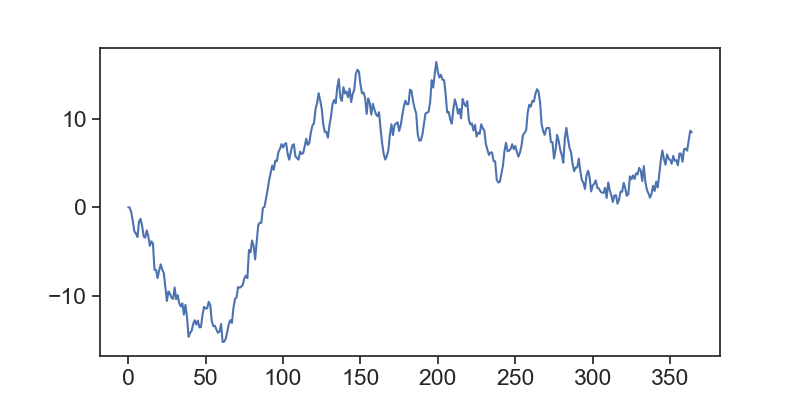

In [67]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(df['B'])
ax.plot(rw39test)

In [52]:
df['date'] = df.index.strftime('%d%m%Y')
df['time'] = df.index.strftime('%H:%M:%S')

In [103]:
df['unix time (s)'] = df.index.view('int64') / 1e9
df

,A,date,unix time (s)
date,,,
2023-01-01,0.000000,2023-01-01,1.672531e+09
2023-01-02,-0.032027,2023-01-02,1.672618e+09
2023-01-03,-0.586351,2023-01-03,1.672704e+09
2023-01-04,-1.575972,2023-01-04,1.672790e+09
2023-01-05,-2.726800,2023-01-05,1.672877e+09
...,...,...,...
2023-12-27,6.651301,2023-12-27,1.703635e+09
2023-12-28,6.415175,2023-12-28,1.703722e+09
2023-12-29,7.603140,2023-12-29,1.703808e+09


In [104]:
df.drop(columns=['date'], inplace=True)
df

,A,unix time (s)
date,,
2023-01-01,0.000000,1.672531e+09
2023-01-02,-0.032027,1.672618e+09
2023-01-03,-0.586351,1.672704e+09
2023-01-04,-1.575972,1.672790e+09
2023-01-05,-2.726800,1.672877e+09
...,...,...
2023-12-27,6.651301,1.703635e+09
2023-12-28,6.415175,1.703722e+09
2023-12-29,7.603140,1.703808e+09


In [60]:
df.loc['2023-10-11 03:00:00', 'B'] = '-'

In [105]:
df.to_csv('cleaning3.csv', index=False, sep=' ')


In [64]:
df['A']

date
2023-01-01 00:00:00     0.000000
2023-01-01 01:00:00    -2.027536
2023-01-01 02:00:00    -2.690617
2023-01-01 03:00:00    -1.985990
2023-01-01 04:00:00    -2.290898
                         ...    
2023-12-31 19:00:00   -74.514645
2023-12-31 20:00:00   -74.738058
2023-12-31 21:00:00   -75.848425
2023-12-31 22:00:00   -77.272183
2023-12-31 23:00:00   -76.557400
Name: A, Length: 8760, dtype: float64

In [72]:
import datetime
import time

dt = datetime.datetime.now()
timestamp = time.mktime(dt.timetuple())
print(timestamp)

1705330442.0


In [73]:
timestamp

1705330442.0

In [74]:
dt

datetime.datetime(2024, 1, 15, 16, 54, 2, 420872)

In [76]:
dt.timetuple()

time.struct_time(tm_year=2024, tm_mon=1, tm_mday=15, tm_hour=16, tm_min=54, tm_sec=2, tm_wday=0, tm_yday=15, tm_isdst=-1)

In [75]:
pd.to_datetime(1705330442.0, unit='s')

Timestamp('2024-01-15 14:54:02')

In [83]:
(df.index.values).apply(lambda x: x.timetuple())

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [85]:
df['date'] = df.index.strftime('%Y-%m-%d')

In [87]:
df['date'].apply(lambda x: x.timetuple())

AttributeError: 'str' object has no attribute 'timetuple'

In [90]:
df.index.to_pydatetime()

array([datetime.datetime(2023, 1, 1, 0, 0),
       datetime.datetime(2023, 1, 2, 0, 0),
       datetime.datetime(2023, 1, 3, 0, 0),
       datetime.datetime(2023, 1, 4, 0, 0),
       datetime.datetime(2023, 1, 5, 0, 0),
       datetime.datetime(2023, 1, 6, 0, 0),
       datetime.datetime(2023, 1, 7, 0, 0),
       datetime.datetime(2023, 1, 8, 0, 0),
       datetime.datetime(2023, 1, 9, 0, 0),
       datetime.datetime(2023, 1, 10, 0, 0),
       datetime.datetime(2023, 1, 11, 0, 0),
       datetime.datetime(2023, 1, 12, 0, 0),
       datetime.datetime(2023, 1, 13, 0, 0),
       datetime.datetime(2023, 1, 14, 0, 0),
       datetime.datetime(2023, 1, 15, 0, 0),
       datetime.datetime(2023, 1, 16, 0, 0),
       datetime.datetime(2023, 1, 17, 0, 0),
       datetime.datetime(2023, 1, 18, 0, 0),
       datetime.datetime(2023, 1, 19, 0, 0),
       datetime.datetime(2023, 1, 20, 0, 0),
       datetime.datetime(2023, 1, 21, 0, 0),
       datetime.datetime(2023, 1, 22, 0, 0),
       datetime.dat

In [98]:
unix = df.index.view('int64') / 1e9

In [101]:
unix[0]

1672531200.0

In [99]:
pd.to_datetime(unix, unit='s')

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=365, freq=None)